In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
concentrations = {
    'c1': 10e-6,
    'c2': 3e-6,
    'c3': 1e-6,
}
concentrations.update({'LC': min(concentrations.values()) / 1e3})
concentrations_log10 = {k: np.log10(v) for k, v in concentrations.items()}
concentrations_log10

{'c1': -5.0, 'c2': -5.522878745280337, 'c3': -6.0, 'LC': -9.0}

In [3]:
compound = 'TI26'
assay = 'TNF'
bname = '../../resources/cell-based-assays/Tina-email-2023-08-31/'
fpath = bname + compound + '_' + assay + '.txt'
data = pd.read_csv(fpath, sep='\t')
data

,VC,c1,c2,c3,RI,LC
0,0.917858,0.755247,9.443050,36.121420,1.403177,13.312150
1,1.303890,7.497930,11.304590,1.577535,0.268734,2.062547
2,0.706698,0.442091,12.486180,28.991770,0.276541,1.752594
3,0.771455,0.958683,4.763406,17.613260,0.812029,1.262600
4,0.394515,0.909701,4.902034,1.180168,0.191152,0.593902
5,0.489854,1.303890,3.428685,8.875549,1.594178,51.612920


In [4]:
df = data[concentrations.keys()].stack().to_frame('readout')
df['conc'] = [concentrations[c] for c in df.index.get_level_values(1)]
df['conc_log10'] = [concentrations_log10[c] for c in df.index.get_level_values(1)]
df

readout          conc  conc_log10
0 c1   0.755247  1.000000e-05   -5.000000
  c2   9.443050  3.000000e-06   -5.522879
  c3  36.121420  1.000000e-06   -6.000000
  LC  13.312150  1.000000e-09   -9.000000
1 c1   7.497930  1.000000e-05   -5.000000
  c2  11.304590  3.000000e-06   -5.522879
  c3   1.577535  1.000000e-06   -6.000000
  LC   2.062547  1.000000e-09   -9.000000
2 c1   0.442091  1.000000e-05   -5.000000
  c2  12.486180  3.000000e-06   -5.522879
  c3  28.991770  1.000000e-06   -6.000000
  LC   1.752594  1.000000e-09   -9.000000
3 c1   0.958683  1.000000e-05   -5.000000
  c2   4.763406  3.000000e-06   -5.522879
  c3  17.613260  1.000000e-06   -6.000000
  LC   1.262600  1.000000e-09   -9.000000
4 c1   0.909701  1.000000e-05   -5.000000
  c2   4.902034  3.000000e-06   -5.522879
  c3   1.180168  1.000000e-06   -6.000000
  LC   0.593902  1.000000e-09   -9.000000
5 c1   1.303890  1.000000e-05   -5.000000
  c2   3.428685  3.000000e-06   -5.522879
  c3   8.875549  1.000000e-06   -6.000000
  LC  51.612920  1.000000e-09   -9.000000

In [5]:
with pm.Model() as mymodel:
    x = df['conc_log10'].values
    y_obs = df['readout'].values
    σ = pm.HalfStudentT("σ", 20, 100)
    β_0 = pm.Normal("β_0", mu=0, sigma=100)
    β_1 = pm.Normal("β_1", mu=0, sigma=50)
    #μ = β_0 + pm.math.dot(x, β_1)
    μ = pm.Deterministic("μ", β_0 + β_1 * x)
    #θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    y = pm.Normal("y", mu=μ, sigma=σ, observed=y_obs)
    regression = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot: title={'center': 'β_0'}>,
        <AxesSubplot: title={'center': 'β_0'}>],
       [<AxesSubplot: title={'center': 'β_1'}>,
        <AxesSubplot: title={'center': 'β_1'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>],
       [<AxesSubplot: title={'center': 'μ'}>,
        <AxesSubplot: title={'center': 'μ'}>]], dtype=object)

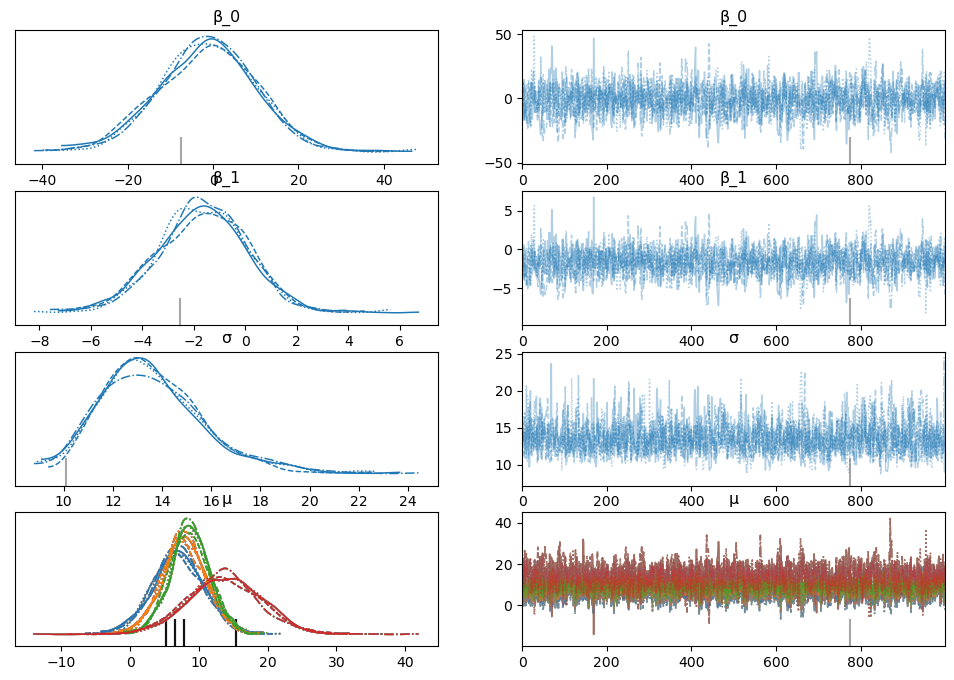

In [11]:
az.plot_trace(regression)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

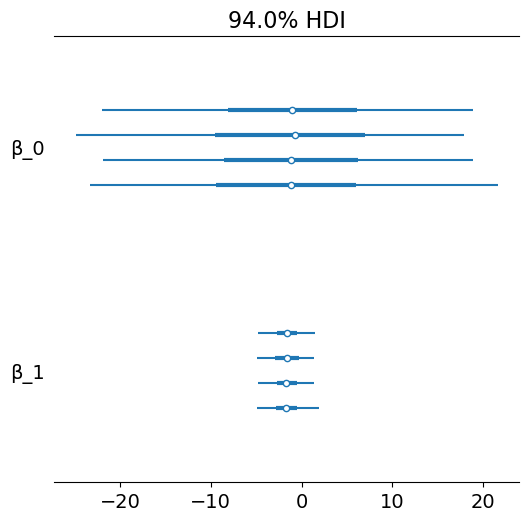

In [29]:
az.plot_forest(regression, var_names=['β_0', 'β_1'])

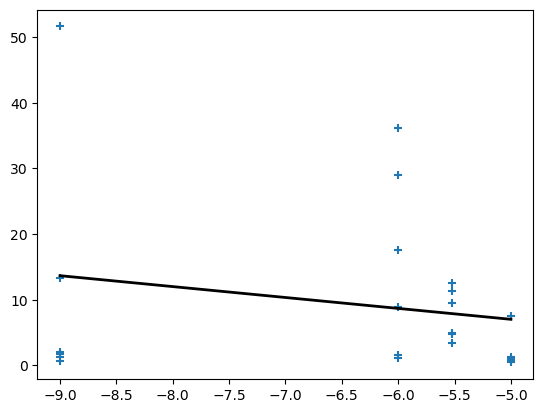

In [26]:
β_0_mean = regression.posterior.mean().to_dict()['data_vars']['β_0']['data']
β_1_mean = regression.posterior.mean().to_dict()['data_vars']['β_1']['data']
xx = np.linspace(df.conc_log10.min(), df.conc_log10.max(), 100)
y_post_mean = β_0_mean + β_1_mean * xx
fig, ax = plt.subplots()
ax.scatter(x='conc_log10', y='readout', data=df, marker='+')
ax.plot(xx, y_post_mean, color='k', linewidth=2)

In [10]:
az.summary(regression)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,-1.291,11.617,-22.948,20.105,0.312,0.248,1416.0,1372.0,1.0
β_1,-1.661,1.758,-4.957,1.426,0.047,0.037,1408.0,1373.0,1.0
σ,13.590,2.127,9.986,17.774,0.052,0.037,1667.0,1605.0,1.0
μ[0],7.016,3.736,0.322,14.432,0.085,0.060,1959.0,2110.0,1.0
μ[1],7.884,3.199,1.720,13.845,0.065,0.046,2419.0,2717.0,1.0
μ[2],8.677,2.882,2.942,13.879,0.052,0.037,3123.0,3006.0,1.0
μ[3],13.661,5.332,4.127,23.940,0.127,0.094,1770.0,1751.0,1.0
μ[4],7.016,3.736,0.322,14.432,0.085,0.060,1959.0,2110.0,1.0
μ[5],7.884,3.199,1.720,13.845,0.065,0.046,2419.0,2717.0,1.0
μ[6],8.677,2.882,2.942,13.879,0.052,0.037,3123.0,3006.0,1.0


In [7]:
%connect_info

{
  "shell_port": 60378,
  "iopub_port": 60379,
  "stdin_port": 60380,
  "control_port": 60382,
  "hb_port": 60381,
  "ip": "127.0.0.1",
  "key": "7e6e41dc-376e01d65dbc837a4b9d8adb",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-57cb3bb3-f7e6-4a41-9f4b-f2db9b08639b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
